# Chapter11. 聚类分析
- 使用k-means算法发现簇中心
- 使用自底向上的方法构建决策树
- 基于密度聚类方法发现任意形状簇

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Sebastian Raschka 
last updated: 2018-10-20 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
matplotlib 2.0.2
scipy 1.1.0
sklearn 0.20.0


## 1. 使用k-means算法对相似对象进行分组

In [1]:
from sklearn.datasets import make_blobs
%matplotlib inline

X, y = make_blobs(n_samples=150, 
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

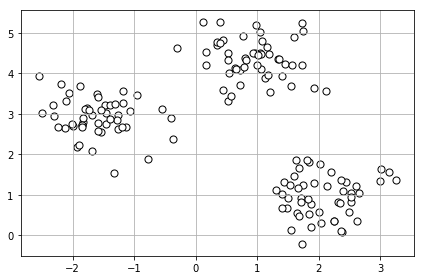

In [2]:
import matplotlib.pyplot as plt

# 新版本的matplotlib的scatter方法需要添加edgecolors来显示点的边缘
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolors='black', s=50)
plt.grid()
plt.tight_layout()
plt.show()

k-means算法：
1. 从样本点中随机选择k个点作为初始簇中心；
2. 将每个样本点划分到距离它最近的中心点 $\mu^{(j)},j\in\{1,...,k\}$ 所代表的簇中；
3. 用各簇中所有样本的中心点（求均值）替代原有的中心点；
4. 重复步骤2和3，直到中心点不变或达到迭代次数。

In [3]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)
# 输出所有点所属的聚类中心
print(y_km)

[1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]


### a. k-means++
k-means++：
1. 初始化一个空集合 $\bf M$，用于存储选定的 $k$ 个中心点；
2. 从输入样本中随机选定第一个中心点 $\mu^{(j)}$，将其加入集合 $\bf M$ 中；
3. 对于集合 $\bf M$ 之外的任一样本点 ${\bf x}^{(j)}$，通过计算找到与其平方距离最小的样本 $d({\bf x}^{(i)}, {\bf M})^2$；
4. 使用加权概率分布 $\frac{d({\bf \mu}^{(p)}, {\bf M})^2}{\sum_id({\bf x}^{(i)}, {\bf M})^2}$来随机选择下一个中心点 $\mu^{(p)}$；
5. 重复步骤2，3，直到选定 $k$ 个中心点；
6. 基于选定的 $k$ 个中心点执行k-means算法；

k-means++算法可以让初始中心点彼此尽可能的远离，相比传统的k-means算法，它可以获得更好、更一致的结果。

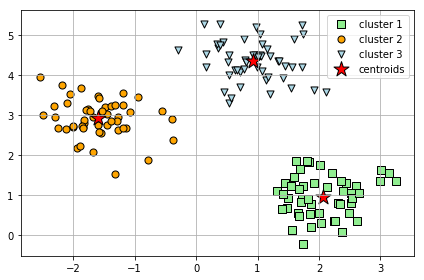

In [4]:
km = KMeans(n_clusters=3, 
            init='k-means++',
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            s=50, color='lightgreen', edgecolors='black',
            marker='s', label='cluster 1')

plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            s=50, color='orange', edgecolors='black',
            marker='o', label='cluster 2')

plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1],
            s=50, color='lightblue', edgecolors='black',
            marker='v', label='cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            color='red', edgecolors='black',
            label='centroids')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

k-means在简单数据集上运行良好，但是也有缺点：
- 我们必须指定先验的簇数量k，但在实际中，这往往是不可知的。
- 簇不可重叠，也不可分层，并且假定了每个簇至少会有一个样本

### b. 硬聚类和软聚类
硬聚类（hard clustering）指的是数据集中每个样本只能划分到一个簇。软聚类（soft clustering），也成模糊聚类可以将一个样本划分到一个或多个簇。常见的软聚类算法是C-means（fuzzy C-means，FCM）。具体算法参见p199。

### c. 使用肘方法确定簇的最佳数量
在完成KMeans拟合后，簇内误差平方和可以直接通过inertia属性来访问：

In [5]:
print("Distortion: %.2f" % km.inertia_)

Distortion: 72.48


基于簇内误差平方和我们可以使用图像工具，即肘方法针对给定任务估计出最优的簇数量k。直观来看，增加k的值可以降低聚类偏差。肘方法的基本理念就是找出聚类偏差骤增时k的值。

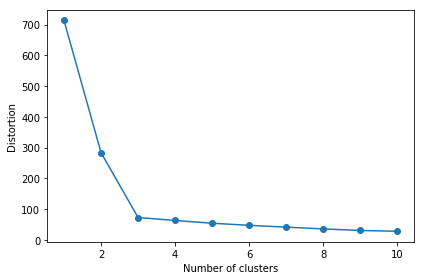

In [6]:
distortion = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortion.append(km.inertia_)
    
plt.plot(range(1, 11), distortion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

可以看到，$k=3$时，图案呈现了肘形，表明对此数据集来说，$k=3$是一个较好的选择。

### d. 通过轮廓图定量分析聚类质量
另一种评估聚类质量的定量分析方法是轮廓分析（silhouette analysis）。轮廓分析可以使用一个图形工具来度量簇中样本聚集的密集程度：
1. 将某一样本 ${\bf x}^{(i)}$ 与簇内其他点之间的平均距离看做是簇的内聚度 $a^{(i)}$；
2. 将样本 ${\bf x}^{(i)}$ 与其最近簇中所有点之间的平均距离看作是下一最近簇的分离度 $b^{(i)}$；
3. 将簇分离度与簇内聚度之差除以二者之中较大者得到轮廓系数：

    $$s^{(i)} = \frac{b^{(i)}-a^{(i)}}{max\{b^{(i)}, a^{(i)}\}}$$
    
轮廓系数介于-1到1之间，簇内聚度和分离度相等（$b^{(i)}=a^{(i)}$），则轮廓系数值为0。由于 $b^{(i)}$ 衡量样本与其他簇的样本之间的差异程度，$a^{(i)}$ 衡量样本与本簇内样的相似程度，所以如果 $b^{(i)}>>a^{(i)}$，那么就可以得到一个近似1的理想值。

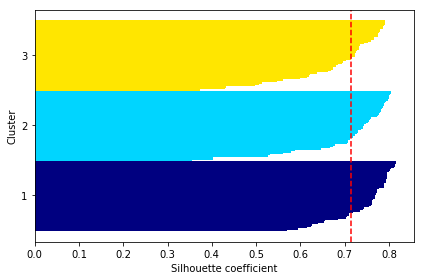

In [7]:
import numpy as np
from matplotlib import cm
# 计算每个样本的轮廓系数
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
# 每个样本的轮廓系数
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    # 第c个簇的样本轮廓系数
    c_silhouette_vals = silhouette_vals[y_km == c]
    # 递增排列
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    # barh绘制水平条形图
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
# 绘制垂直线
plt.axvline(silhouette_avg, color='red', linestyle='--')

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

从图中可以看到轮库系数均未接近0点，所以聚类效果不错。

为了了解效果不佳的轮廓图，我们使用两个聚类中心来初始化k-means算法：

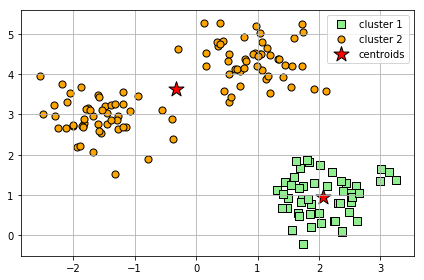

In [8]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300, 
            tol=1e-04, 
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1',
            edgecolors='black')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2',
            edgecolors='black')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, 
            marker='*', color='red', edgecolors='black', label='centroids')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

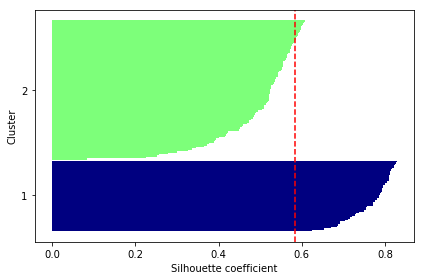

In [9]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

从图中可见，轮廓明显有着不同的长度，说明效果不佳

## 2. 层次聚类
层次聚类允许我们绘制树状图，有助于我们解释聚类结果，而且层次聚类无需事先指定簇的数量。层次聚类主要有两种方法：凝聚层次聚类和分裂层次聚类。在分裂层次聚类中，我们首先把所有样本看做同一个簇，然后迭代地将簇划分为更小的簇，直到每个簇只包含一个样本。凝聚层次聚类则相反，最初我们把每个样本都看作一个单独的簇，重复地将最近的簇进行合并，直到所有样本都在一个簇中为止。

凝聚层次聚类中，判定簇间距离的两个标准方法是单连接和全连接：
1. 计算得到所有样本间的距离矩阵；
2. 将每个数据点看作是一个单独的簇；
3. 基于最不相似（距离最远）样本的距离，合并两个最接近的簇；
4. 更新相似矩阵；
5. 重复2到4，知道所有样本都合并到一个簇为止。

In [10]:
import pandas as pd
import numpy as np

np.random.seed(123)

# 特征值
variables = ['X', 'Y', 'Z']
# 样本
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

# 生成随机5个样本，每个样本3个特征
X = np.random.random_sample([5, 3]) * 10
# 将生成的样本转换成DataFrame
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### a. 基于距离矩阵进行层次聚类

In [11]:
from scipy.spatial.distance import pdist, squareform

# 计算样本之间的欧几里得距离，生成距离矩阵，是一个对称阵
# pdist生成的是一个m(m-1)/2的行向量，是由距离方阵的上三角转换而来的，(1,2) (1,3)...(2,3) (2,4)...
# squareform是将pdist转换为对称的方阵。
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


我们使用Scipy中的cluster.hierarchy子模块下的linkage函数，它以全连接作为距离判定标准，返回一个关联矩阵。从linkage函数的描述中可知：我们可以将由pdist函数得到的稠密上三角阵作为输入，或者将初始化的欧几里得距离矩阵作为linkage的输入，不过我们不能使用squareform得到的矩阵作为输入。因为这会产生和预期不同的距离值：

In [12]:
# 1. 错误的方法：使用squareform作为输入

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust'],
             index=['cluster %d' % (i+1)
                    for i in range(row_clusters.shape[0])])

/home/zero/Software/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


,row label 1,row label 2,distance,no. of items in clust
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [13]:
# 2. 正确的方法：使用pdist产生的向量作为输入

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [14]:
# 3. 正确的方法：使用原始的矩阵作为输入

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


关联矩阵包含了多行，每一行代表一次合并。矩阵的第一列和第二列分别表示每个簇中最不相似（距离最远）的样本，第三列是它们之间的距离，最后一列是每个簇中所含样本的数量。

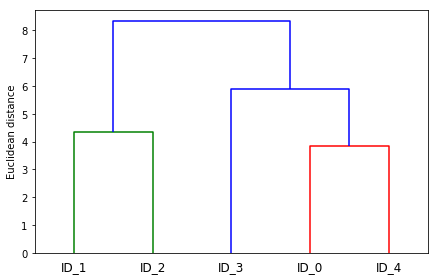

In [15]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters,
                       labels=labels)

plt.tight_layout()
plt.ylabel("Euclidean distance")
plt.show()

In [16]:
row_dendr

{'color_list': ['g', 'r', 'b', 'b'],
 'dcoord': [[0.0, 4.3470733871677325, 4.3470733871677325, 0.0],
  [0.0, 3.8353955541370812, 3.8353955541370812, 0.0],
  [0.0, 5.8998850390851292, 5.8998850390851292, 3.8353955541370812],
  [4.3470733871677325,
   8.3165936661140201,
   8.3165936661140201,
   5.8998850390851292]],
 'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'ivl': ['ID_1', 'ID_2', 'ID_3', 'ID_0', 'ID_4'],
 'leaves': [1, 2, 3, 0, 4]}

上图着色方案来自Matplotlib的一个色彩列表，它基于树状图中的距离阈值循环生成不同颜色。

### 2. 树状图与热度图的关联
在实际应用中，树状图通常和热度图结合使用，这样我们可以使用不同的颜色来代表样本矩阵中的独立值。

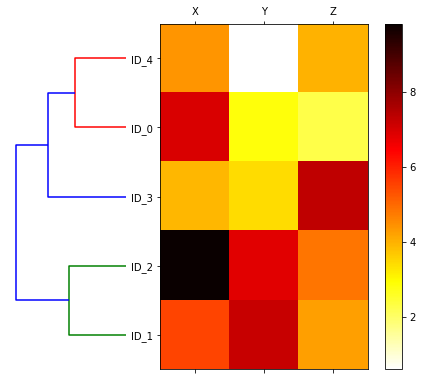

In [17]:
# 创建一个figure对象，并使用add_axes属性设定x,y轴的位置，以及树状图的宽度和高度，同时将树状图旋转90度
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
# 旋转树状图
row_dendr = dendrogram(row_clusters, orientation='left')

# 根据树状图中的簇类标重排DataFrame中的数据
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

# 移除树状图中的坐标轴
axd.set_xticks([])
axd.set_yticks([])

# 移除坐标点
for i in axd.spines.values():
    i.set_visible(False)
    
# 绘制热图
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])    # x-pos, y-pos, width, height。和上面的是对应的
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

### c. 使用sklearn进行凝聚聚类

In [18]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')

labels = ac.fit_predict(X)
print("Cluster labels: %s" % labels)

Cluster labels: [0 1 1 0 0]


## 3. 使用DBSCAN划分高密度区域
基于密度空间的聚类算法（Density-Based Spatial Clustering of Applications with Noise，DBSCAN）。密度被定义为指定半径  $\varepsilon$ 范围内的样本数量。

在DBSCAN中，基于以下标准，每个点都被赋予了一个特殊的标签：
- 如果在一个点周边指定的半径 $\varepsilon$ 内，其他点的数量不小于指定数量（MinPts），则称此样本点为核心点（Core Point）；
- 在指定半径 $\varepsilon$ 内，如果一个点的邻居少于MinPts个，但是却包含一个核心点，那么称此点为边界点（Border Point）；
- 除了核心点和边界点外的其他样本点成为噪声点（Noise Point）。

完成对点的标记后，DBSCAN算法可以按照如下步骤进行：
1. 基于每个核心点或者一组相连的核心点（如果核心点的距离很近，则将其看作是相连的）形成一个单独的簇；
2. 将每个边界点划分到其对应核心点所在的簇中。

下面我们创建一个半月形的数据集，以对比k-means、层次聚类和DBSCAN聚类：

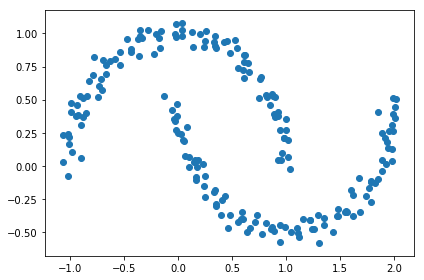

In [19]:
from sklearn.datasets import  make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

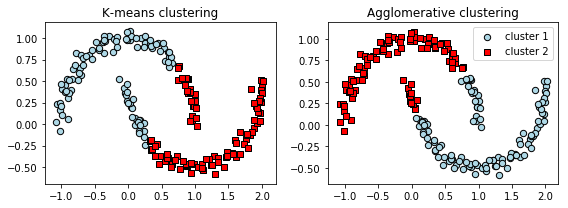

In [20]:
# 首先使用k-means和层次聚类
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            color='lightblue', marker='o', edgecolors='black',
            s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            color='red', marker='s', edgecolors='black',
            s=40, label='cluster 2')
ax1.set_title("K-means clustering")

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            marker='o', edgecolors='black', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            marker='s', edgecolors='black', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
plt.show()

从图中可见，这两种算法都无法将数据集完全分开，这种复杂的数据结构对其也是一种挑战。下面使用DBSCAN方法对数据集进行测试：

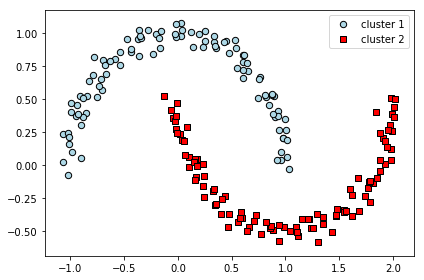

In [22]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', edgecolors='black', marker='o', s=40,
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', edgecolors='black', marker='s', s=40,
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

可以看到，DBSCAN对于这种高密度的数据集具有良好的聚类效果。